In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

In [2]:
## CALCULATE STROMA SCORE
# df = pd.read_excel("../data/TCGA_MEASUREMENTS.xlsx")
# Should we compute score before or after split, or in general have same cuts for all (as technically we don't know 
# labels for the test set)
SEED = 0

def specificity(y_true, y_pred):
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))

    N = len(y_true) -np.sum(y_true)
    
    return TN/N

def calculate_stroma_score(df, allCuts=None, allWeights=None):
#     df = pd.read_excel(data_dir)
    no_rows = len(df)
    classes_col = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]

    x = df.to_numpy()
    x[:, -1] = x[:, -1] / 365.35  # convert 'days to event' to 'years to event'
    x[:, 11] = x[:, 11] / 10  # convert 'years to birth' to 'decades to birth'
    x = np.append(x, np.zeros((no_rows, 1)), axis=1)  # add column for HD score

    if allWeights is None:
        # Calculate allWeights
        df["years_to_event"] = (
            df["days_to_event"] / 365.25
        )  # convert 'days to event' to 'years to event'
        df["decades_to_birth"] = (
            df["years_to_birth"] / 10
        )  # convert 'years to birth' to 'decades to birth'
        y = df[["years_to_event", "vital_status"]]

        cph_models = [
            CoxPHFitter().fit(
                pd.concat([df[col], y], axis=1), "years_to_event", "vital_status"
            )
            for col in classes_col
        ]
        allWeights = np.array([float(cph.summary["exp(coef)"]) for cph in cph_models])

        
        
    # Calculate allCuts?
    # allCuts = np.array(
    #     [
    #         0.00056,
    #         0.00227,
    #         0.03151,
    #         0.00121,
    #         0.01123,
    #         0.02359,
    #         0.06405,
    #         0.00122,
    #         0.99961,
    #     ]
    # )  # Youden cuts
    
    if allCuts==None:

        allCuts = []

        for i, col_name in enumerate(classes_col):
            class_score = df[col_name]
            max_index = 0
            median = np.median(class_score)
            for j, score in enumerate(class_score):
                if j == 0:
                    allCuts.append(score)

                preds = np.greater_equal(class_score, score).astype(int)
                sens = recall_score(df["vital_status"], preds)
                spec = specificity(df["vital_status"], preds)
                if (sens + spec) > max_index:
                    max_index = sens + spec
                    allCuts[i] = score
                elif sens + spec == max_index:
                    if abs(score - median) < abs(allCuts[i] - median):
                        allCuts[i] = score
                        max_index = score

    # Calculate stroma score
    scoreIndices = (np.argwhere(allWeights >= 1)).flatten()
    for i in scoreIndices:
        x[:, -1] = (
            x[:, -1] + (x[:, i + 1] >= allCuts[i]) * allWeights[i]
        )  # +1 retrieve column number in x
    medianTrainingSet = np.median(x[:, -1])
    x[:, -1] = (x[:, -1] >= medianTrainingSet) * 1
    stroma_score = x[:, -1]

    return stroma_score, allCuts, allWeights


## Original excel

In [3]:
df = pd.read_excel("../data/TCGA_MEASUREMENTS.xlsx")
df["years_to_event"] = df["days_to_event"]/365.25
df["decades_to_birth"] = df["years_to_birth"]/10

In [4]:
classes_col = ["ADI","BACK", "DEB", "LYM", "MUC","MUS", "NORM", "STR","TUM"]

In [5]:
y = df[["years_to_event","vital_status"]]
y_days = df[["days_to_event","vital_status"]]

In [6]:
df.head()

,ID,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM,...,histological_type,hypermutated,methylation_subtype,CAF_SCORE,percent_stromal_cells,RF_predictedCMS,cleanstage,days_to_event,years_to_event,decades_to_birth
0,TCGA-CM-6675,0.000284,0.000204,0.090979,0.000544,0.013228,0.007923,0.101498,0.086859,0.798861,...,colon adenocarcinoma,0.0,CIMP-H,2.080628,12,CMS1,4.0,397,1.086927,3.5
1,TCGA-AY-A8YK,0.000324,0.000290,0.004827,0.013253,0.004651,0.002694,0.066702,0.140175,0.767085,...,colon adenocarcinoma,NaN,NaN,1.635184,7,NaN,4.0,573,1.568789,4.4
2,TCGA-CM-4747,0.001219,0.004085,0.197126,0.337597,0.002646,0.003099,0.158479,0.447476,0.485696,...,colon adenocarcinoma,0.0,CIMP-L,2.024608,15,NaN,4.0,761,2.083504,4.7
3,TCGA-DY-A1DG,0.003772,0.001362,0.188463,0.002173,0.012698,0.063342,0.096374,0.012094,0.619722,...,rectal adenocarcinoma,NaN,Cluster3,0.990050,0,NaN,4.0,1566,4.287474,7.5
4,TCGA-CM-5862,0.007687,0.006287,0.386051,0.086920,0.132158,0.130372,0.076991,0.102107,0.481279,...,colon adenocarcinoma,0.0,Cluster3,1.944954,0,CMS2,4.0,153,0.418891,8.0


In [7]:
selected_columns = ["obtained_scores" ,"cleanstage", "gender", "decades_to_birth" ]
df_mv = df.copy()
df_mv = df_mv.dropna(subset=["cleanstage", "decades_to_birth"])
y_mv = df_mv[["years_to_event","vital_status"]]

## Our values

In [8]:
df_avg = pd.read_csv("../data/TCGA_SA_data_average.csv",)

df_avg["years_to_event"] = df_avg["days_to_event"]/365.25 # convert 'days to event' to 'years to event'
df_avg["decades_to_birth"] = df_avg["years_to_birth"]/10 # 
df_avg = df_avg[df_mv.columns]
df_avg = df_avg.dropna(subset=["cleanstage", "decades_to_birth"])

df_avg_train = df_avg.sample(frac=0.8, random_state=SEED)
df_avg_test = df_avg.drop(df_avg_train.index)

In [9]:
df_org_train = df_mv.loc[df_mv['ID'].isin(df_avg_train["ID"])]
df_org_test = df_mv.loc[df_mv['ID'].isin(df_avg_test["ID"])]

y_org_train = df_org_train[["years_to_event","vital_status"]]
y_org_test = df_org_test[["years_to_event","vital_status"]]

y_avg_train = df_avg_train[["years_to_event","vital_status"]]
y_avg_test = df_avg_test[["years_to_event","vital_status"]]

In [10]:
df_avg_train["obtained_scores"],allCuts,allWeights = calculate_stroma_score(df_avg_train)
df_avg_test["obtained_scores"],_,_ = calculate_stroma_score(df_avg_test, allCuts, allWeights)

In [11]:
df_org_train["obtained_scores"], allCuts, allWeights = calculate_stroma_score(df_org_train)
df_org_test["obtained_scores"],_,_ = calculate_stroma_score(df_org_test, allCuts, allWeights)

/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["years_to_event"] = (
/tmp/ipykernel_57466/1779275358.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decades_to_birth"] = (
/tmp/ipykernel_57466/1914456348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [12]:
# print(mv_regression_df)
mv_cox_orginal_data = CoxPHFitter().fit(pd.concat([df_org_train[selected_columns], y_org_train], axis=1), "years_to_event", "vital_status", 
                           formula = "obtained_scores + cleanstage + C(gender) +decades_to_birth" )


In [13]:
mv_cox_orginal_data.print_summary()

<lifelines.CoxPHFitter: fitted with 270 total observations, 212 right-censored observations>
             duration col = 'years_to_event'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 270
number of events observed = 58
   partial log-likelihood = -256.01
         time fit was run = 2022-12-10 19:48:36 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
C(gender)[T.male]     -0.29       0.75       0.27            -0.82             0.24                 0.44                 1.27
cleanstage             0.92       2.50       0.16             0.59             1.24                 1.81                 3.46
decades_to_birth       0.35       1.41       0.11             0.13             0.56                 1.14                 1.75
obtained_scores[T.1]   0.79       2.21       0.32             0.17             1.41                 1.18                 4.11

                       cmp to     z      p   -log2(p)
covariate                                            
C(gender)[T.male]        0.00 -1.08   0.28       1.83
cleanstage               0.00  5.57 <0.005      25.19
decades_to_birth         0.00  3.20 <0.005       9.49
obtained_scores[T.1]     0.00  2.49   0.01       6.31
---
Concordance = 0.75
Partial AIC = 520.02
log-likelihood ratio test = 47.96 on 4 df
-log2(p) of ll-ratio test = 29.95

In [14]:
concordance_results = {}
org_c = concordance_index(df_org_test['years_to_event'], 
                  -mv_cox_orginal_data.predict_partial_hazard(df_org_test), df_org_test['vital_status'])

concordance_results["original"] = org_c

In [15]:
mv_cox_avg = CoxPHFitter().fit(pd.concat([df_avg_train[selected_columns], y_avg_train], axis=1), "years_to_event", "vital_status", 
                           formula = "obtained_scores + cleanstage + C(gender) +decades_to_birth" )
concordance_results["avg"] = concordance_index(df_avg_test['years_to_event'], 
                  -mv_cox_avg.predict_partial_hazard(df_avg_test), df_avg_test['vital_status'])

In [16]:
mv_cox_avg.print_summary()
print(concordance_results)

<lifelines.CoxPHFitter: fitted with 270 total observations, 212 right-censored observations>
             duration col = 'years_to_event'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 270
number of events observed = 58
   partial log-likelihood = -259.00
         time fit was run = 2022-12-10 19:48:38 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
C(gender)[T.male]     -0.23       0.80       0.27            -0.75             0.30                 0.47                 1.34
cleanstage             0.90       2.46       0.16             0.58             1.22                 1.79                 3.38
decades_to_birth       0.33       1.39       0.11             0.12             0.54                 1.12                 1.72
obtained_scores[T.1]   0.28       1.33       0.28            -0.26             0.83                 0.77                 2.29

                       cmp to     z      p   -log2(p)
covariate                                            
C(gender)[T.male]        0.00 -0.85   0.39       1.34
cleanstage               0.00  5.58 <0.005      25.29
decades_to_birth         0.00  3.02 <0.005       8.62
obtained_scores[T.1]     0.00  1.03   0.31       1.71
---
Concordance = 0.74
Partial AIC = 525.99
log-likelihood ratio test = 41.98 on 4 df
-log2(p) of ll-ratio test = 25.83

{'original': 0.7927728613569321, 'avg': 0.7927728613569321}


## Our data - highest probability

In [17]:
df_highest = pd.read_csv("../data/TCGA_SA_data_highest_tum.csv",)

df_highest["years_to_event"] = df_highest["days_to_event"]/365.25 # convert 'days to event' to 'years to event'
df_highest["decades_to_birth"] = df_highest["years_to_birth"]/10 # 
df_highest = df_highest[df_mv.columns]
df_highest = df_highest.dropna(subset=["cleanstage", "decades_to_birth"])

df_highest_train = df_highest.loc[df_highest['ID'].isin(df_avg_train["ID"])]
df_highest_test = df_highest.loc[df_highest['ID'].isin(df_avg_test["ID"])]

df_highest_train["obtained_scores"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
df_highest_test["obtained_scores"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)

/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["years_to_event"] = (
/tmp/ipykernel_57466/1779275358.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decades_to_birth"] = (
/tmp/ipykernel_57466/1577166827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [18]:
y_highest  = df_highest[["years_to_event","vital_status"]]

In [19]:
mv_cox_highest = CoxPHFitter().fit(df_highest_train, "years_to_event", "vital_status", 
                           formula = "obtained_scores + cleanstage + C(gender) +decades_to_birth" )


In [20]:
mv_cox_highest.print_summary()

<lifelines.CoxPHFitter: fitted with 270 total observations, 212 right-censored observations>
             duration col = 'years_to_event'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 270
number of events observed = 58
   partial log-likelihood = -259.34
         time fit was run = 2022-12-10 19:48:43 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
C(gender)[T.male]     -0.21       0.81       0.27            -0.74             0.31                 0.48                 1.37
cleanstage             0.91       2.48       0.16             0.59             1.23                 1.81                 3.40
decades_to_birth       0.33       1.40       0.11             0.12             0.55                 1.12                 1.73
obtained_scores[T.1]   0.18       1.20       0.29            -0.38             0.74                 0.68                 2.10

                       cmp to     z      p   -log2(p)
covariate                                            
C(gender)[T.male]        0.00 -0.80   0.43       1.23
cleanstage               0.00  5.62 <0.005      25.65
decades_to_birth         0.00  3.03 <0.005       8.65
obtained_scores[T.1]     0.00  0.62   0.53       0.91
---
Concordance = 0.74
Partial AIC = 526.67
log-likelihood ratio test = 41.30 on 4 df
-log2(p) of ll-ratio test = 25.36

In [21]:
concordance_results["highest"] = concordance_index(df_highest_test['years_to_event'], 
                  -mv_cox_highest.predict_partial_hazard(df_highest_test), df_highest_test['vital_status'])

In [22]:
print(concordance_results)

{'original': 0.7927728613569321, 'avg': 0.7927728613569321, 'highest': 0.7876106194690266}


## Only raw probabilities from model

In [23]:
cols_with_classes = ["cleanstage", "gender", "decades_to_birth", "ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]
mv_cox_raw = CoxPHFitter().fit(df_org_train, "years_to_event", "vital_status", 
                           formula = "ADI + BACK + DEB + LYM + MUC+ MUS + NORM + STR + TUM + cleanstage + C(gender) +decades_to_birth" )

In [24]:
mv_cox_raw.print_summary()

<lifelines.CoxPHFitter: fitted with 270 total observations, 212 right-censored observations>
             duration col = 'years_to_event'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 270
number of events observed = 58
   partial log-likelihood = -254.55
         time fit was run = 2022-12-10 19:48:44 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
ADI                 0.50       1.64       3.08            -5.54             6.53                 0.00               685.25
BACK                0.56       1.75       6.81           -12.78            13.90                 0.00             1.08e+06
C(gender)[T.male]  -0.38       0.69       0.29            -0.95             0.19                 0.39                 1.21
DEB                 2.14       8.48       1.15            -0.12             4.39                 0.89                80.81
LYM                -0.01       0.99       0.93            -1.84             1.83                 0.16                 6.20
MUC                -0.27       0.77       1.42            -3.05             2.52                 0.05                12.39
MUS                 0.39       1.48       0.94            -1.44             2.23                 0.24                 9.29
NORM               -0.53       0.59       1.23            -2.94             1.89                 0.05                 6.60
STR                -0.48       0.62       1.24            -2.91             1.95                 0.05                 7.01
TUM                -0.81       0.45       0.75            -2.27             0.66                 0.10                 1.94
cleanstage          1.02       2.77       0.18             0.67             1.36                 1.96                 3.91
decades_to_birth    0.34       1.41       0.11             0.12             0.57                 1.13                 1.76

                    cmp to     z      p   -log2(p)
covariate                                         
ADI                   0.00  0.16   0.87       0.20
BACK                  0.00  0.08   0.93       0.10
C(gender)[T.male]     0.00 -1.31   0.19       2.38
DEB                   0.00  1.86   0.06       3.99
LYM                   0.00 -0.01   0.99       0.01
MUC                   0.00 -0.19   0.85       0.23
MUS                   0.00  0.42   0.68       0.57
NORM                  0.00 -0.43   0.67       0.58
STR                   0.00 -0.39   0.70       0.52
TUM                   0.00 -1.08   0.28       1.83
cleanstage            0.00  5.78 <0.005      27.03
decades_to_birth      0.00  3.04 <0.005       8.70
---
Concordance = 0.75
Partial AIC = 533.10
log-likelihood ratio test = 50.87 on 12 df
-log2(p) of ll-ratio test = 19.96

In [25]:
concordance_results["raw_probs"] = concordance_index(df_org_test['years_to_event'], 
                  -mv_cox_raw.predict_partial_hazard(df_org_test), df_org_test['vital_status'])
print(concordance_results)

{'original': 0.7927728613569321, 'avg': 0.7927728613569321, 'highest': 0.7876106194690266, 'raw_probs': 0.8171091445427728}


## 10-fold CV

In [26]:
from sklearn.model_selection import KFold

concordance_results_cv = {"original": [], "average": [], "highest": [], "raw_probabilities": []}
selected_columns = ["stroma_score" ,"cleanstage" , "gender", "decades_to_birth"]

kf = KFold(n_splits=10, shuffle=True,random_state=SEED)

for train, test in kf.split(df_avg):
    df_avg_train = df_avg.iloc[train]
    df_avg_test = df_avg.iloc[test]
    df_avg_train["stroma_score"],allCuts,allWeights = calculate_stroma_score(df_avg_train)
    df_avg_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test, allCuts, allWeights)

    mv_cox_avg = CoxPHFitter().fit(df_avg_train, "years_to_event", "vital_status", 
                           formula = "stroma_score + cleanstage + C(gender) +decades_to_birth" )
#     print(df_avg_train.dtypes, df_avg_test.dtypes)
    concordance_results_cv["average"].append(concordance_index(df_avg_test['years_to_event'], 
                  -mv_cox_avg.predict_partial_hazard(df_avg_test[selected_columns]), df_avg_test['vital_status']))
    
    
    df_org_train = df_mv.loc[df_mv['ID'].isin(df_avg_train["ID"])]
    df_org_test = df_mv.loc[df_mv['ID'].isin(df_avg_test["ID"])]
    df_org_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_org_train)
    df_org_test["stroma_score"],_,_ = calculate_stroma_score(df_org_test, allCuts, allWeights)
    
    mv_cox_orginal_data = CoxPHFitter().fit(df_org_train, "years_to_event", "vital_status", 
                           formula = "stroma_score + cleanstage + C(gender) +decades_to_birth" )
    concordance_results_cv["original"].append(concordance_index(df_org_test['years_to_event'], 
                  -mv_cox_orginal_data.predict_partial_hazard(df_org_test), df_org_test['vital_status']))
    
    
    
    
    
    df_highest_train = df_highest.loc[df_highest['ID'].isin(df_avg_train["ID"])]
    df_highest_test = df_highest.loc[df_highest['ID'].isin(df_avg_test["ID"])]
    df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
    df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)
    
    mv_cox_highest = CoxPHFitter().fit(df_highest_train, "years_to_event", "vital_status", 
                           formula = "stroma_score + cleanstage + C(gender) +decades_to_birth" )
    
    concordance_results_cv["highest"].append(concordance_index(df_highest_test['years_to_event'], 
                  -mv_cox_highest.predict_partial_hazard(df_highest_test), df_highest_test['vital_status']))
    
    
    mv_cox_raw = CoxPHFitter().fit(df_org_train, "years_to_event", "vital_status", 
                           formula = "ADI + BACK + DEB + LYM + MUC+ MUS + NORM + STR + TUM + cleanstage + C(gender) +decades_to_birth" )
    
    concordance_results_cv["raw_probabilities"].append(concordance_index(df_org_test['years_to_event'], 
                  -mv_cox_raw.predict_partial_hazard(df_org_test), df_org_test['vital_status']))
    
    

    



/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["years_to_event"] = (
/tmp/ipykernel_57466/1779275358.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decades_to_birth"] = (
/tmp/ipykernel_57466/2743264023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

/tmp/ipykernel_57466/2743264023.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
/tmp/ipykernel_57466/2743264023.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)
/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipykernel_57466/2743264023.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
/tmp/ipykernel_57466/2743264023.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)
/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipykernel_57466/2743264023.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
/tmp/ipykernel_57466/2743264023.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)
/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipykernel_57466/2743264023.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
/tmp/ipykernel_57466/2743264023.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)
/tmp/ipykernel_57466/1779275358.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipykernel_57466/2743264023.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_train["stroma_score"], allCuts, allWeights = calculate_stroma_score(df_highest_train)
/tmp/ipykernel_57466/2743264023.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_test["stroma_score"],_,_ = calculate_stroma_score(df_avg_test,allCuts, allWeights)


In [27]:
print(concordance_results_cv)

{'original': [0.6975308641975309, 0.6754385964912281, 0.6507936507936508, 0.6190476190476191, 0.927710843373494, 0.5610687022900763, 0.8467741935483871, 0.7161290322580646, 0.8979591836734694, 0.755868544600939], 'average': [0.6481481481481481, 0.7456140350877193, 0.6428571428571429, 0.6571428571428571, 0.9457831325301205, 0.5419847328244275, 0.7741935483870968, 0.6838709677419355, 0.826530612244898, 0.755868544600939], 'highest': [0.6419753086419753, 0.7368421052631579, 0.5714285714285714, 0.6476190476190476, 0.9457831325301205, 0.5534351145038168, 0.8682795698924731, 0.6580645161290323, 0.8877551020408163, 0.7605633802816901], 'raw_probabilities': [0.6234567901234568, 0.7719298245614035, 0.6587301587301587, 0.6095238095238096, 0.9216867469879518, 0.5648854961832062, 0.8494623655913979, 0.6580645161290323, 0.9081632653061225, 0.784037558685446]}


In [45]:
cv_results = {key:sum(val)/len(val) for key, val in concordance_results_cv.items()}
print(cv_results)

{'original': 0.7348321230274458, 'average': 0.7221993721565284, 'highest': 0.7271745848330701, 'raw_probabilities': 0.7349940531821986}


In [31]:
df_results = pd.DataFrame(concordance_results_cv)

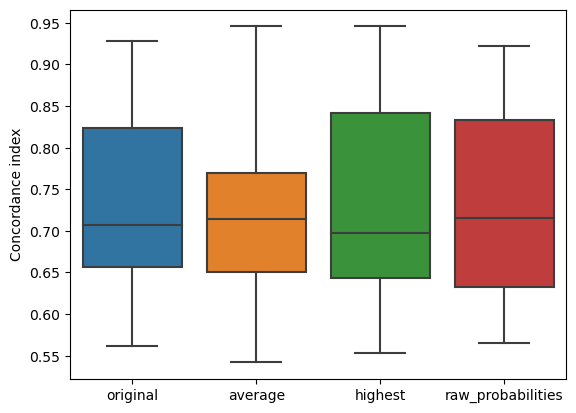

In [44]:
import seaborn as sns

fig = sns.boxplot(data=df_results)
fig.set_ylabel("Concordance index")

fig = fig.get_figure()
fig.savefig("boxplot concordance.png", dpi = 400)